In [10]:
import pennylane as qml
import tensorflow as tf
import sklearn.datasets
from sklearn.datasets import fetch_openml

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

tf.keras.backend.set_floatx('float64')

## Load and reduce the data

Load the MNIST data and check number of training and test examples

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0  # add colour dimension

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Create a function to filter out only 0 and 1

In [12]:
def filter_01(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [13]:
x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))
pd.Series(y_train).value_counts()

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True     6131
False    5918
dtype: int64

Plot the original images

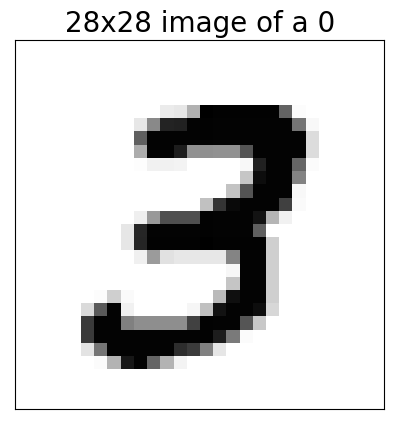

In [14]:
plt.imshow(x_train[0, :, :, 0], cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("28x28 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('28x28_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Reduce images to 9x9

In [15]:
x_train_small = tf.image.resize(x_train, (9,9)).numpy()
x_test_small = tf.image.resize(x_test, (9,9)).numpy()

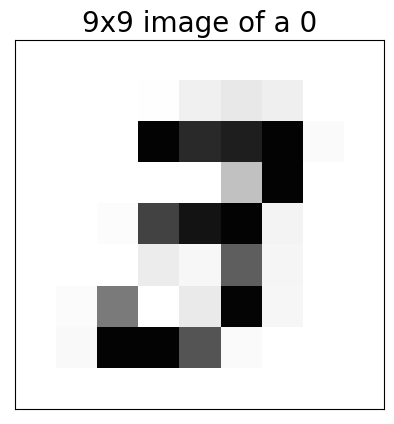

In [16]:
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("9x9 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('9x9_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Further reduce images to 9x1

(12049, 9)


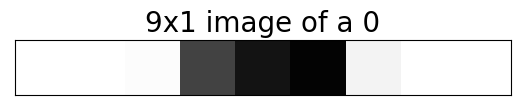

In [17]:
x_train_small = x_train_small[:,4,:,:].reshape((-1,9))  # take only central slices
x_test_small = x_test_small[:,4,:,:].reshape((-1,9))  # take only central slices
print(x_train_small.shape)
plt.imshow(x_train_small[0,:].reshape((1,-1)), vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("9x1 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('9x1_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


## Set up the Quantum Neural Network

Create quantum circuit using pennylane qnode, then conver this to a Keras layer to make a Keras model

In [18]:
n_qubits = 9
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")
outputs = qlayer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model.predict(x_train_small[0,:])
print(model.summary())

1/1 [==============================] - 0s 426ms/step
Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 9)]               0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 51        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def create_quantum_model(n_qubits, n_layers):
    
    # Create a quantum device with the specified number of qubits
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, diff_method="adjoint")
    def qnode(inputs, weights):
        
        # Apply RY rotations based on input values
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[ii], wires=ii)

        # Apply quantum layers
        for jj in range(n_layers):
            for ii in range(n_qubits-1):
                
                # Apply RZ, RY, RZ gates on wire 0
                qml.RZ(weights[jj, 2*ii, 0], wires=0)
                qml.RY(weights[jj, 2*ii, 1], wires=0)
                qml.RZ(weights[jj, 2*ii, 2], wires=0)

                # Apply RZ, RY, RZ gates on wire (ii + 1)
                qml.RZ(weights[jj, 2*ii+1, 0], wires=ii+1)
                qml.RY(weights[jj, 2*ii+1, 1], wires=ii+1)
                qml.RZ(weights[jj, 2*ii+1, 2], wires=ii+1)

                # Apply CNOT gate between wire (ii + 1) and wire 0
                qml.CNOT(wires=[ii+1, 0])

            # Apply RZ, RY, RZ gates on wire 0 after the CNOTs
            qml.RZ(weights[jj, 2*(n_qubits-1), 0], wires=0)
            qml.RY(weights[jj, 2*(n_qubits-1), 1], wires=0)
            qml.RZ(weights[jj, 2*(n_qubits-1), 2], wires=0)

        # Measure the expectation value of Pauli-Z on wire 0
        return qml.expval(qml.PauliZ(0))

    # Define weight shapes for the KerasLayer
    weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3)}

    # Create the quantum layer with the qnode and weight_shapes
    qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")

    # Create the Keras input layer with the shape of the inputs
    inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")

    # Connect the quantum layer to the inputs
    outputs = qlayer(inputs)

    # Create the Keras model with the inputs and outputs
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

    return model, qnode

model, q_node = create_quantum_model(n_qubits, n_layers)
model.predict(x_train_sliced[0,:])
print(model.summary())
plot_model(model, to_file="quantum_ml_model.png", show_shapes=True, show_dtype=True, show_layer_names=True)

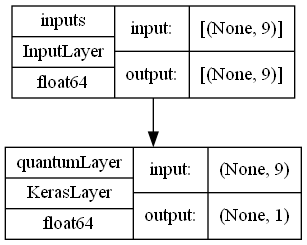

In [22]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="quantum_ml_model.png", show_shapes=True, show_dtype=True, show_layer_names=True)

In [21]:
circuit_diagram = qml.draw(qnode)
sample_inputs = np.random.rand(n_qubits)
sample_weights = np.random.rand(n_layers, 2*(n_qubits-1)+1, 3)

print(circuit_diagram(sample_inputs, sample_weights))

0: ──RY(2.75)──RZ(0.90)──RY(0.21)──RZ(0.65)─╭X──RZ(0.18)──RY(0.33)──RZ(0.20)─╭X──RZ(0.14)──RY(0.39)
1: ──RY(1.97)──RZ(0.79)──RY(0.41)──RZ(0.53)─╰●───────────────────────────────│─────────────────────
2: ──RY(2.92)──RZ(0.20)──RY(0.90)──RZ(0.58)──────────────────────────────────╰●────────────────────
3: ──RY(0.63)──RZ(0.21)──RY(0.64)──RZ(0.95)────────────────────────────────────────────────────────
4: ──RY(2.56)──RZ(0.26)──RY(0.63)──RZ(0.27)────────────────────────────────────────────────────────
5: ──RY(3.05)──RZ(0.18)──RY(0.16)──RZ(0.44)────────────────────────────────────────────────────────
6: ──RY(1.74)──RZ(0.18)──RY(0.66)──RZ(0.02)────────────────────────────────────────────────────────
7: ──RY(0.42)──RZ(0.74)──RY(0.86)──RZ(0.51)────────────────────────────────────────────────────────
8: ──RY(1.12)──RZ(0.63)──RY(0.90)──RZ(0.19)────────────────────────────────────────────────────────

───RZ(0.57)─╭X──RZ(0.25)──RY(0.35)──RZ(0.22)─╭X──RZ(0.75)──RY(0.04)──RZ(0.52)─╭X──RZ(0.70)──RY(0.53

Redefine the classification values to match the Hinge loss

In [34]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

Define the hinge accuracy

In [35]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

## Compile and train the model

Compile the model using the hinge loss and accuracy and the Adam optimiser

In [36]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [37]:
print(model.summary())

Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 9)]               0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 51        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
None


Train the model over 20 epochs

In [39]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_small[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_small[:,:]
y_test_sub = y_test[:]

qnn_history_1layer = model.fit(
      x_train_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_sub, y_test_sub))

qnn_results_1layer = model.evaluate(x_test_sub, y_test_sub)

512
Epoch 1/20
16/16 [==============================] - 116s 8s/step - loss: 0.7949 - hinge_accuracy: 0.7754 - val_loss: 0.7842 - val_hinge_accuracy: 0.8029
Epoch 2/20
16/16 [==============================] - 129s 8s/step - loss: 0.7478 - hinge_accuracy: 0.8398 - val_loss: 0.7406 - val_hinge_accuracy: 0.8619
Epoch 3/20
16/16 [==============================] - 130s 8s/step - loss: 0.6949 - hinge_accuracy: 0.9082 - val_loss: 0.6912 - val_hinge_accuracy: 0.8886
Epoch 4/20
16/16 [==============================] - 122s 8s/step - loss: 0.6369 - hinge_accuracy: 0.9238 - val_loss: 0.6366 - val_hinge_accuracy: 0.9027
Epoch 5/20
16/16 [==============================] - 122s 8s/step - loss: 0.5746 - hinge_accuracy: 0.9355 - val_loss: 0.5780 - val_hinge_accuracy: 0.9254
Epoch 6/20
16/16 [==============================] - 124s 8s/step - loss: 0.5098 - hinge_accuracy: 0.9531 - val_loss: 0.5184 - val_hinge_accuracy: 0.9420
Epoch 7/20
16/16 [==============================] - 122s 8s/step - loss: 0.445

In [49]:
qnn_history_1layer.history

{'loss': [0.7948610737076639,
  0.747792502576677,
  0.6949325005123872,
  0.63687125836657,
  0.5746490536454402,
  0.5097967228108742,
  0.4452283333492036,
  0.3837232509988997,
  0.326215743752812,
  0.275303303158548,
  0.2329972143218012,
  0.1973051505247757,
  0.16970821046253975,
  0.14815786166757106,
  0.13192971004601295,
  0.11967931721619546,
  0.11047155728175485,
  0.103677711187808,
  0.09814878346648996,
  0.0939320501603964],
 'hinge_accuracy': [0.775390625,
  0.83984375,
  0.908203125,
  0.923828125,
  0.935546875,
  0.953125,
  0.97265625,
  0.98046875,
  0.984375,
  0.984375,
  0.98828125,
  0.98828125,
  0.9921875,
  0.9921875,
  0.9921875,
  0.9921875,
  0.9921875,
  0.9921875,
  0.9921875,
  0.9921875],
 'val_loss': [0.7841518037654658,
  0.7405903996850309,
  0.6912318639937944,
  0.636639164014819,
  0.5780122791066481,
  0.5183518558250495,
  0.45866246354486634,
  0.40181119262681886,
  0.3503085625247908,
  0.30593768987919956,
  0.2679786654576807,
  0.23

Create and train a 2 layer version of the QNN

In [41]:
n_qubits = 9
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")
outputs = qlayer(inputs)
model2 = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model2.predict(x_train_small[0,:])
print(model2.summary())

1/1 [==============================] - 0s 94ms/step
Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 9)]               0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 102       
                                                                 
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
model2.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [43]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_small[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_small[:,:]
y_test_sub = y_test[:]

qnn_history_2layer = model2.fit(
      x_train_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_sub, y_test_sub))

qnn_results_2layer = model2.evaluate(x_test_sub, y_test_sub)

512
Epoch 1/20
16/16 [==============================] - 221s 14s/step - loss: 1.3413 - hinge_accuracy: 0.1426 - val_loss: 1.3481 - val_hinge_accuracy: 0.1159
Epoch 2/20
16/16 [==============================] - 230s 15s/step - loss: 1.2572 - hinge_accuracy: 0.1738 - val_loss: 1.2678 - val_hinge_accuracy: 0.1497
Epoch 3/20
16/16 [==============================] - 223s 14s/step - loss: 1.1718 - hinge_accuracy: 0.2227 - val_loss: 1.1823 - val_hinge_accuracy: 0.2087
Epoch 4/20
16/16 [==============================] - 225s 15s/step - loss: 1.0806 - hinge_accuracy: 0.3242 - val_loss: 1.0901 - val_hinge_accuracy: 0.3392
Epoch 5/20
16/16 [==============================] - 230s 15s/step - loss: 0.9835 - hinge_accuracy: 0.5137 - val_loss: 0.9902 - val_hinge_accuracy: 0.5197
Epoch 6/20
16/16 [==============================] - 226s 15s/step - loss: 0.8788 - hinge_accuracy: 0.6738 - val_loss: 0.8858 - val_hinge_accuracy: 0.6573
Epoch 7/20
16/16 [==============================] - 219s 14s/step - loss

In [45]:
qnn_history_2layer.history

{'loss': [1.3413382869175614,
  1.257158245783547,
  1.1717778574682909,
  1.0805867696149776,
  0.9834880632450164,
  0.8788159335340346,
  0.7720185404790528,
  0.6648715723502568,
  0.5650397934258788,
  0.4750214415105203,
  0.39739542345157464,
  0.33343198183226064,
  0.2813899822297749,
  0.23949438801413053,
  0.20422700741697178,
  0.17526618262852978,
  0.15071860022352598,
  0.1294208141592533,
  0.11144211520870792,
  0.09621070616034656],
 'hinge_accuracy': [0.142578125,
  0.173828125,
  0.22265625,
  0.32421875,
  0.513671875,
  0.673828125,
  0.81640625,
  0.91796875,
  0.958984375,
  0.96484375,
  0.978515625,
  0.984375,
  0.990234375,
  0.99609375,
  0.99609375,
  0.998046875,
  0.998046875,
  0.998046875,
  0.998046875,
  1.0],
 'val_loss': [1.3480957858191063,
  1.2678485014292395,
  1.1822944548006231,
  1.0900566090809363,
  0.9902096832225786,
  0.8858413965523876,
  0.778242943948875,
  0.6742622187171513,
  0.5775994367846176,
  0.49206464410612855,
  0.4202296

## Plot the results!

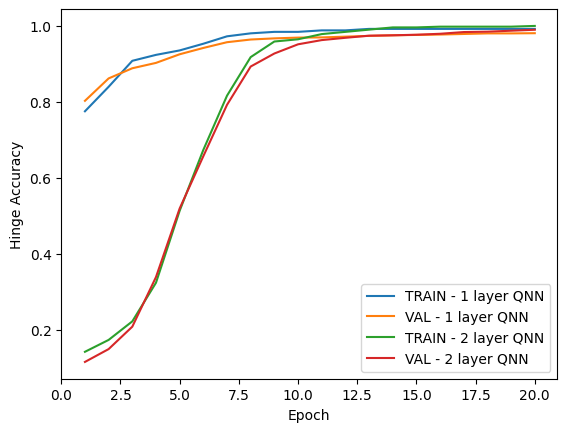

In [47]:
# plot the hinge accuracy for the qnn history for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), qnn_history_1layer.history["hinge_accuracy"], label="TRAIN - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_1layer.history["val_hinge_accuracy"], label="VAL - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["hinge_accuracy"], label="TRAIN - 2 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["val_hinge_accuracy"], label="VAL - 2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("qnn_hinge_accuracy.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

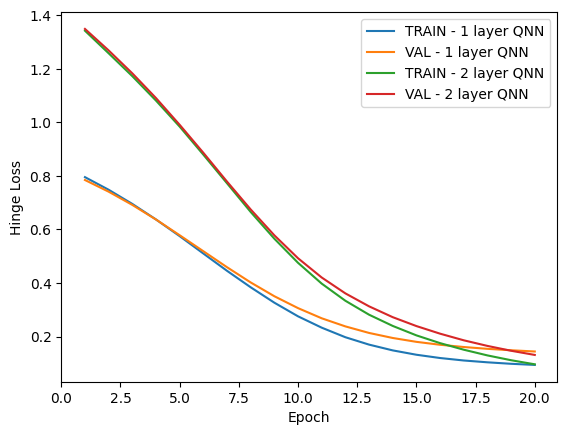

In [48]:
# plot the hinge accuracy for the loss for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), qnn_history_1layer.history["loss"], label="TRAIN - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_1layer.history["val_loss"], label="VAL - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["loss"], label="TRAIN - 2 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["val_loss"], label="VAL - 2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("qnn_hinge_loss.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
    #--------------- PLOT CONFUSION MATRIX -----------------
    y_pred = model.predict(x_test_sub)
    y_pred = np.argmax(y_pred, axis=1)
    y_test_sub = np.argmax(y_test_sub, axis=1)
    cm = confusion_matrix(y_test_sub, y_pred)
    print(cm)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig("QML_model_experiment_{}_confusion_matrix.png".format(key))
    plt.clf()
    
    #--------------- PLOT CLASSIFICATION REPORT -----------------
    print(classification_report(y_test_sub, y_pred))
    plt.figure(figsize=(10,10))
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.title("Confusion matrix")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig("QML_model_experiment_{}_confusion_matrix_norm.png".format(key))
    plt.clf()

    #--------------- PLOT ROC CURVE -----------------
    # plot ROC curve using the already calculated metrics
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test_sub, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_sub.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(10):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= 10

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,10))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'purple', 'pink', 'brown', 'black'])
    for i, color in zip(range(10), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig("QML_model_experiment_{}_roc_curve.png".format(key))
    plt.clf()

    #--------------- PLOT PRECISION-RECALL CURVE -----------------
    # plot precision-recall curve using the already calculated metrics
    precision = dict()
    recall = dict()
    pr_auc = dict()
    for i in range(10):
        precision[i], recall[i], _ = precision_recall_curve(y_test_sub, y_pred)
        pr_auc[i] = auc(recall[i], precision[i])
    
    # Compute micro-average ROC curve and ROC area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_sub.ravel(), y_pred.ravel())
    pr_auc["micro"] = auc(recall["micro"], precision["micro"])

    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_recall = np.unique(np.concatenate([recall[i] for i in range(10)]))

    # Then interpolate all ROC curves at this points
    mean_precision = np.zeros_like(all_recall)
    for i in range(10):
        mean_precision += interp(all_recall, recall[i], precision[i])
    
    # Finally average it and compute AUC
    mean_precision /= 10

    recall["macro"] = all_recall
    precision["macro"] = mean_precision
    pr_auc["macro"] = auc(recall["macro"], precision["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,10))
    plt.plot(recall["micro"], precision["micro"],
            label='micro-average Precision-Recall curve (area = {0:0.2f})'
                ''.format(pr_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(recall["macro"], precision["macro"],
            label='macro-average Precision-Recall curve (area = {0:0.2f})'
                ''.format(pr_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'purple', 'pink', 'brown', 'black'])
    for i, color in zip(range(10), colors):

In [ ]:
 #--------------- SAVE MODEL AS TFLITE -----------------
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    open("QML_model_experiment_{}.tflite".format(key), "wb").write(tflite_model)

    #--------------- SAVE MODEL AS TFLITE QUANTIZED -----------------
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_quant_model = converter.convert()
    open("QML_model_experiment_{}_quantized.tflite".format(key), "wb").write(tflite_quant_model)

    #--------------- SAVE MODEL AS TFLITE QUANTIZED WITH POST TRAINING QUANTIZATION -----------------
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
    tflite_quant_model = converter.convert()
    open("QML_model_experiment_{}_quantized_post_training.tflite".format(key), "wb").write(tflite_quant_model)

    #--------------- SAVE MODEL AS TFLITE QUANTIZED WITH POST TRAINING QUANTIZATION AND QUANTIZATION RANGE -----------------
    def representative_dataset_gen():
        for input_value in tf.data.Dataset.from_tensor_slices(x_train_sub).batch(1).take(100):
            yield [input_value]
        
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
    converter.representative_dataset = representative_dataset_gen
    tflite_quant_model = converter.convert()
    open("QML_model_experiment_{}_quantized_post_training_quantization_range.tflite".format(key), "wb").write(tflite_quant_model)

   
    